## 导入需要的库

In [58]:

import sys
import numpy as np
sys.path.append("C:\\Users\\RS\\VSCode\\matchedfiltermethod")

from matplotlib import pyplot as plt # type: ignore
import matplotlib.cm as cm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from MatchedFilter import matched_filter as mf
from MatchedFilter import generate_uas as gu
from MyFunctions import needed_function as nf
from MyFunctions import radiance_lut as rl


import MyFunctions.AHSI_data as ad
import MyFunctions.EMIT_data as ed
from MyFunctions.needed_function import open_unit_absorption_spectrum


## 必要的函数


In [89]:
def profile_matched_filter(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum
    concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 
    return concentration[0]


# def profile_matched_filter_ML(base_array, data_array: np.array,unit_absorption_spectrum: np.array) :
#     # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
#     background_spectrum = base_array
#     target_spectrum = background_spectrum*unit_absorption_spectrum[0]
#     concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 

#     if concentration[0] > 4000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[1]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 4000
#     if concentration[0] > 8000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[2]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 8000
#     if concentration[0] > 12000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[3]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 12000
#     if concentration[0] > 16000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[4]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 16000
#     if concentration[0] > 20000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[5]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 20000
#     if concentration[0] > 24000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[6]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 24000
#     if concentration[0] > 28000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[7]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 28000
#     if concentration[0] > 32000:
#         background_spectrum = background_spectrum + 4000*target_spectrum
#         target_spectrum = background_spectrum*unit_absorption_spectrum[8]
#         concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
#         concentration[0] = concentration[0] + 32000
    
    
#     return concentration[0]


def profile_matched_filter_ML(base_array, data_array: np.array,unit_absorption_spectrum: np.array) :
    # 直接通过背景光谱和目标光谱拟合甲烷浓度增强结果
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None) 

    threshold = 4000
    if concentration[0] > threshold and threshold < 33000:
        background_spectrum = background_spectrum + 4000*target_spectrum
        target_spectrum = background_spectrum*unit_absorption_spectrum[threshold//4000]
        concentration, _, _, _ = np.linalg.lstsq(target_spectrum[:, np.newaxis],(data_array - background_spectrum), rcond=None)
        concentration[0] = concentration[0] + threshold
     
    return concentration[0]


def matched_filter_with_fixed_bg(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands,rows,cols = data_array.shape
    concentration = np.zeros((rows,cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]

    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands,bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:,i,j], d_covariance[:,i,j])
    covariance /= rows*cols
    covariance_inverse = np.linalg.pinv(covariance)
    
    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i,j] = up / down
    
    return concentration


def ML_matched_filter_with_fixed_bg(base_array, data_array: np.array, unit_absorption_spectrum: np.array) :
    # 获取数据 波段 行数 列数 信息， 初始化浓度矩阵
    bands,rows,cols = data_array.shape
    concentration = np.zeros((rows,cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱，再计算目标光谱与背景光谱的差值
    background_spectrum = base_array
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    
    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_back
    covariance = np.zeros((bands,bands))
    for i in range(rows):
        for j in range(cols):
            covariance += np.outer(d_covariance[:,i,j], d_covariance[:,i,j])
    covariance /= rows*cols
    covariance_inverse = np.linalg.inv(covariance)
    
    # 计算每个像素的甲烷浓度增强结果
    for i in range(rows):
        for j in range(cols):
            up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
            down = target_spectrum.T @ covariance_inverse @ target_spectrum
            concentration[i,j] = up / down
            
    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[1]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 4000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 4000
    
    # 对于浓度增强大于一定值的像素，使用分层算法进行计算
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[2]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 8000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 8000
    
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[3]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 12000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 12000
    
    background_spectrum = background_spectrum + 4000*target_spectrum
    target_spectrum = background_spectrum*unit_absorption_spectrum[4]
    radiancediff_with_back = data_array - background_spectrum[:,np.newaxis,np.newaxis]
    for i in range(rows):
        for j in range(cols):
            if concentration[i,j] > 16000:
                up = (radiancediff_with_back[:,i,j].T @ covariance_inverse @ target_spectrum)
                down = target_spectrum.T @ covariance_inverse @ target_spectrum
                concentration[i,j] = up / down + 16000
    
    return concentration


def image_simulation(plume, lower_wavelength, upper_wavelength, row_num, col_num,noise_level):
    # Load the simulated emit radiance spectrum
    total_bands,lut = rl.load_lookup_table("C:\\Users\\RS\\VSCode\matchedfiltermethod\\MyData\\enhanced_radiance\\AHSI_rad_lookup_table.npz")
    
    bands,unenhanced_radiance = rl.lookup_spectrum(0,total_bands,lut,lower_wavelength,upper_wavelength)
    # Set the shape of the image that want to simulate
    band_num = len(bands)
    simulated_image = np.zeros([band_num, row_num, col_num])
    # Generate the universal radiance cube image
    for i in range(row_num) :
        for j in range(col_num) :
            if plume[i,j] > 0:
                _,enhanced_radiance = rl.lookup_spectrum(plume[i,j],total_bands,lut,lower_wavelength,upper_wavelength)
                simulated_image[:,i,j] = enhanced_radiance
            else:
                simulated_image[:,i,j] = unenhanced_radiance
    # 为每个波段添加 1% 的高斯噪声
    noise_std = noise_level * simulated_image  # 噪声的标准差为辐亮度的 1%
    noise = np.random.normal(0, noise_std)
    simulated_noisy_image = simulated_image + noise 
  
    return simulated_noisy_image


def enhancement_2perc(enhancement):
    np.random.seed(42)  
    matrix_size = 100
    indices = np.random.choice(matrix_size * matrix_size, 200, replace=False)
    plume = np.zeros((matrix_size, matrix_size))
    np.put(plume, indices, enhancement)
    
    # 选取剩余的像素点作为未增强的像素点,并将选取的像素点转换为行列索引，分别是增强和未增强的像素点
    all_indices = np.arange(plume.size)
    unenhanced_indices = np.setdiff1d(all_indices, indices)
    enhanced_mask = np.unravel_index(indices, (matrix_size, matrix_size))
    unenhanced_mask = np.unravel_index(unenhanced_indices, (matrix_size, matrix_size))
    
    # 生成模拟影像
    simulated_image = image_simulation(plume,2150, 2500, 100, 100, 0.01)
    return simulated_image,enhanced_mask,unenhanced_mask


def polyfit_plot(enhancements,resultlist,ax,labelstr):
    slope,intercept = np.polyfit(enhancements,resultlist,1)
    x_fit = np.linspace(min(enhancements), max(enhancements), 100)
    y_fit = slope * x_fit + intercept
    if intercept > 0 :
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x + {np.abs(intercept):.2f}' )
    elif intercept < 0 :
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x - {np.abs(intercept):.2f}' )
    else:
        ax.plot(x_fit,y_fit,label=f'{labelstr}:y = {slope:.2f}x' )


def set_plot_details(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    
def test(method,ax,*args):
    tif_file_path = r"F:\\AHSI_part1\\GF5B_AHSI_E100.0_N26.4_20231004_011029_L10000400374\\GF5B_AHSI_E100.0_N26.4_20231004_011029_L10000400374_SW.tif"
    bands,radiance = ad.get_calibrated_radiance(tif_file_path,2100,2500)
    # define the path of the unit absorption spectrum file
    ahsi_unit_absorption_spectrum_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_50000.txt"
    bands, uas = open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2100,2500)
    # call the main function to process the radiance file 
    c = method(radiance,uas,*args)
    # 创建网格
    x = np.arange(c.shape[1])  # 列索引
    y = np.arange(c.shape[0])  # 行索引
    X, Y = np.meshgrid(x, y)
    contour = ax.contourf(X, Y, c, 20, cmap='RdGy')



# 算法编写

## 常规匹配滤波算法

### 整幅影像计算

C:\Users\RS\AppData\Local\Temp\ipykernel_36536\3663452450.py:81: RuntimeWarning: overflow encountered in scalar divide
  concentration[row,col] = np.maximum(numerator / denominator, 0.0)


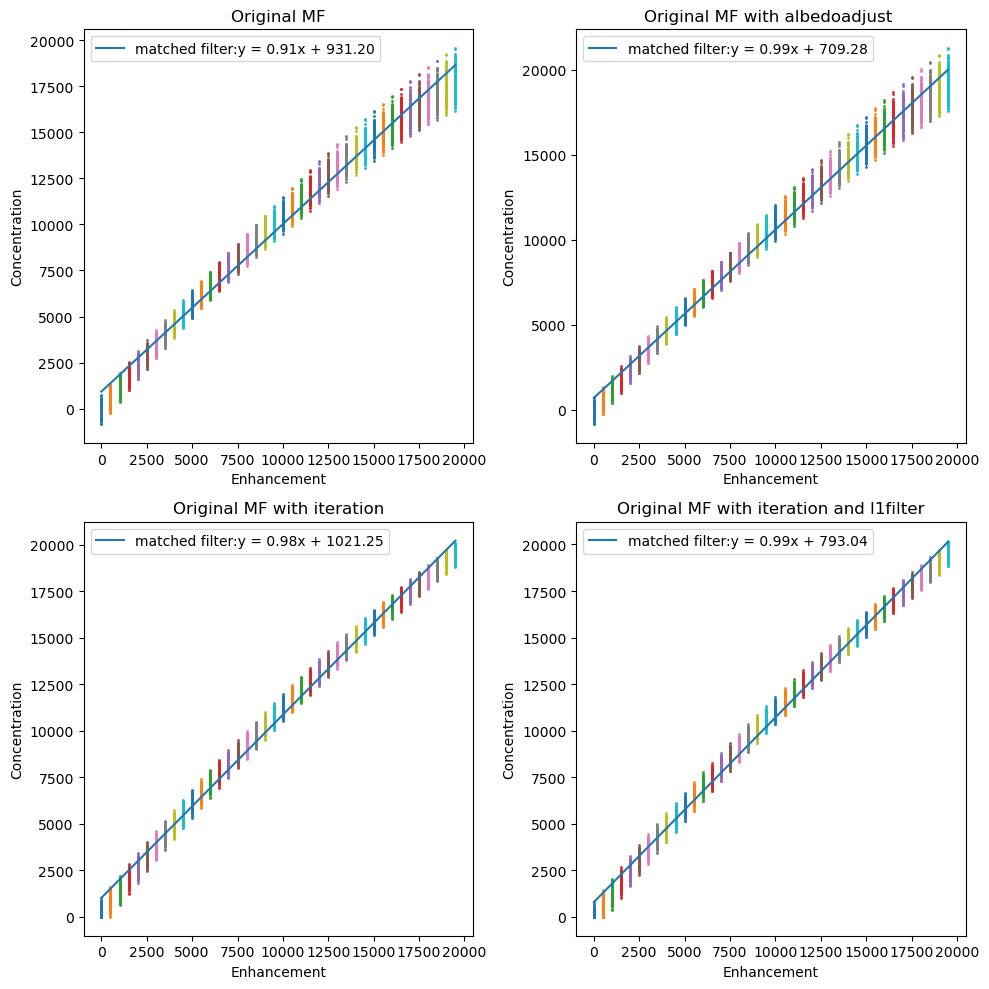

In [117]:
# original matched filter algorithm 整幅图像进行计算
def matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array, albedoadjust, iterate, sparsity):        
    """
    Calculate the methane enhancement of the image data based on the original matched filter
    and the unit absorption spectrum.
    
    :param data_array: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param albedoadjust: bool, whether to adjust the albedo
    :param iterate: bool, whether to iterate
    :param sparsity: bool, whether to use l1filter
    
    :return: numpy array of the methane enhancement
    """
    # 获取波段 行数 列数 初始化 concentration 数组，大小与卫星数据尺寸一直
    bands, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    background_spectrum = np.nanmean(data_cube, axis=(1,2))
    target_spectrum = background_spectrum*unit_absorption_spectrum
    radiancediff_with_bg = data_cube - background_spectrum[:, None,None]
    
    # 计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_bg
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.pinv(covariance)
    
    # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
    albedo = np.ones((rows, cols))
    if albedoadjust:
        for row in range(rows):
            for col in range(cols):
                albedo[row, col] = (
                        (data_cube[:,row,col].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                )
    
    # 基于最优化公式计算每个像素的甲烷浓度增强值
    for row in range(rows):
        for col in range(cols):
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum)
            denominator = albedo[row,col]*(target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[row,col] = numerator/denominator

    # 判断是否进行迭代，若是，则进行如下迭代计算
    if iterate:
        # 初始化 l1filter 数组
        l1filter = np.zeros((rows,cols))
        for iter_num in range(5):
            # 判断是否进行 l1filter 校正，若是则给予前一步的浓度值计算 l1filter
            if sparsity:
                for row in range(rows):
                    for col in range(cols):
                        l1filter[row,col] = 1 / (concentration[row,col] + np.finfo(np.float64).tiny)
            
            # 更新背景光谱和目标光谱,并计算进行观测光谱和背景光谱差值   
            background_spectrum = np.mean(data_cube - (albedo*concentration)[None,:,:]*target_spectrum[:,None,None],
                                          axis=(1,2))
            target_spectrum = np.multiply(background_spectrum, unit_absorption_spectrum)
            radiancediff_with_bg = data_cube - background_spectrum[:,None,None]
            
            # 基于新的目标谱和背景光谱 计算协方差矩阵
            d_covariance = data_cube -(albedo*concentration)[None,:,:]*target_spectrum[:,None,None] - background_spectrum[:,None,None]
            covariance = np.zeros((bands, bands))
            for row in range(rows):
                for col in range(cols):
                    covariance += np.outer(d_covariance[:,row,col], d_covariance[:,row,col])
            covariance = covariance/(rows*cols)
            covariance_inverse = np.linalg.pinv(covariance)

            # 基于最优化估计公式 计算新的甲烷浓度增强值
            for row in range(rows):
                for col in range(cols):
                    numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum) - l1filter[row,col]
                    denominator = albedo[row,col] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                    concentration[row,col] = np.maximum(numerator / denominator, 0.0)
                    
    return concentration


def mf_run_plot(ax,*args):
    _,uas = gu.generate_range_uas_AHSI(0,36000,2150,2500) 
    resultlist = []
    enhancements = np.arange(0,20000,500)
    for enhancement in enhancements:
        # 生成2%像素浓度增强的模拟影像
        simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
        # 使用匹配滤波算法计算浓度增强
        result = matched_filter(simulated_image,uas,*args)
        # 计算增强和未增强像素的平均浓度
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
    
    polyfit_plot(enhancements,resultlist,ax,"matched filter")
    

def matched_filter_test():
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = axes.flatten()
    mf_run_plot(ax1,False,False,False)
    mf_run_plot(ax2,True,False,False)
    mf_run_plot(ax3,False,True,False)
    mf_run_plot(ax4,False,True,True)
    set_plot_details(ax1, "Original MF", "Enhancement", "Concentration")
    set_plot_details(ax2, "Original MF with albedoadjust ", "Enhancement", "Concentration")
    set_plot_details(ax3, "Original MF with iteration", "Enhancement", "Concentration")
    set_plot_details(ax4, "Original MF with iteration and l1filter", "Enhancement", "Concentration")

    plt.tight_layout()
    plt.show()
    
    return None

matched_filter_test()

### column-wise 进行计算

C:\Users\RS\AppData\Local\Temp\ipykernel_10600\647088855.py:93: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ax.contourf)


AttributeError: 'function' object has no attribute 'get_array'

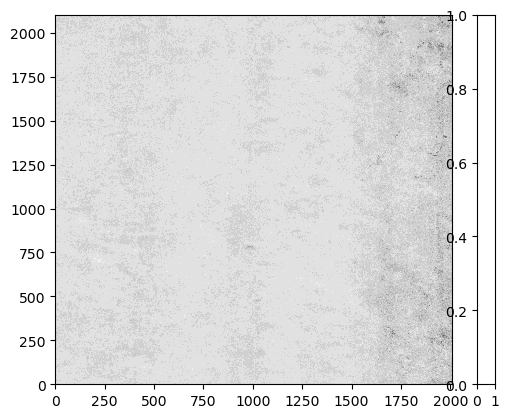

In [ ]:
# orginal matched filter algorithm 逐列计算
def columnwise_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array, iterate=False,
                   albedoadjust=False, sparsity=False):
    """
    Calculate the methane enhancement of the image data based on the original matched filter
    and the unit absorption spectrum.
    
    :param data_array: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param albedoadjust: bool, whether to adjust the albedo
    :param iterate: bool, whether to iterate
    :param sparsity: bool, whether to use l1filter
    :return: numpy array of the methane enhancement
    """
    # 获取波段 行数 列数 ,并初始化 concentration 数组
    bands, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    
    # 遍历不同列数，目的是为了消除 不同传感器之间带来的误差
    for col_index in range(cols):
        # 获取当前列的数据 获取当前列的非空行的 索引 以及 数目
        current_column = data_cube[:, :, col_index]
        valid_rows = ~np.isnan(current_column[0, :])
        count_not_nan = np.count_nonzero(valid_rows)
        
        # 对于全为空的列，直接将浓度值设为 nan
        if count_not_nan == 0:
            concentration[:, col_index] = np.nan
            continue

        # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱,并计算观测光谱和背景光谱的差值
        background_spectrum = np.nanmean(current_column, axis=1)
        target_spectrum = background_spectrum*unit_absorption_spectrum
        radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None]
        
        # 计算协方差矩阵，并获得其逆矩阵
        d_covariance = radiancediff_with_bg
        covariance = np.zeros((bands, bands))
        for i in range(count_not_nan):
            covariance += np.outer(d_covariance[:, i], d_covariance[:, i])
        covariance = covariance/count_not_nan
        covariance_inverse = np.linalg.pinv(covariance)

        # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
        albedo = np.ones((rows, cols))
        if albedoadjust:
            albedo[valid_rows, col_index] = (
                    (current_column[:, valid_rows].T @ background_spectrum) /
                    (background_spectrum.T @ background_spectrum)
            )

        # 基于最优化公式计算每个像素的甲烷浓度增强值
        numerator = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum)
        denominator = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
        concentration[valid_rows, col_index] = numerator/denominator
        
        # 判断是否进行迭代，若是，则进行如下迭代计算
        if iterate:
            # 初始化 l1filter 数组
            l1filter = np.zeros((rows, cols))
            epsilon = np.finfo(np.float64).tiny
            # 迭代计算
            for iter_num in range(5):
                print("iteration: No.", iter_num + 1)
                # 判断是否进行 l1filter 校正，若是则给予前一步的浓度值计算 l1filter
                if sparsity:
                    l1filter[valid_rows, col_index] = 1 / (concentration[valid_rows, col_index] + epsilon)
        
                # 更新背景光谱和目标光谱，计算进行观测光谱和背景光谱差值
                background_spectrum = np.nanmean(current_column[:, valid_rows] - (albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None],
                                                 axis=1)
                target_spectrum = np.multiply(background_spectrum, unit_absorption_spectrum)
                radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum
                
                # 基于新的目标谱 和 背景光谱 计算协方差矩阵
                d_covariance = current_column[:, valid_rows] -(albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None] - background_spectrum[:,None]
                covariance = np.zeros((bands, bands))
                for i in range(valid_rows.shape[0]):
                    covariance += np.outer(d_covariance[:, i], d_covariance[:, i])
                covariance = covariance/count_not_nan
                covariance_inverse = np.linalg.pinv(covariance)

                # 计算新的甲烷浓度增强值
                numerator = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum) - l1filter[valid_rows, col_index]
                denominator = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                concentration[valid_rows, col_index] = np.maximum(numerator / denominator, 0.0)
                
    # 返回甲烷浓度增强和反照率校正
    return concentration


## 多层匹配滤波算法

### 整幅图像进行计算

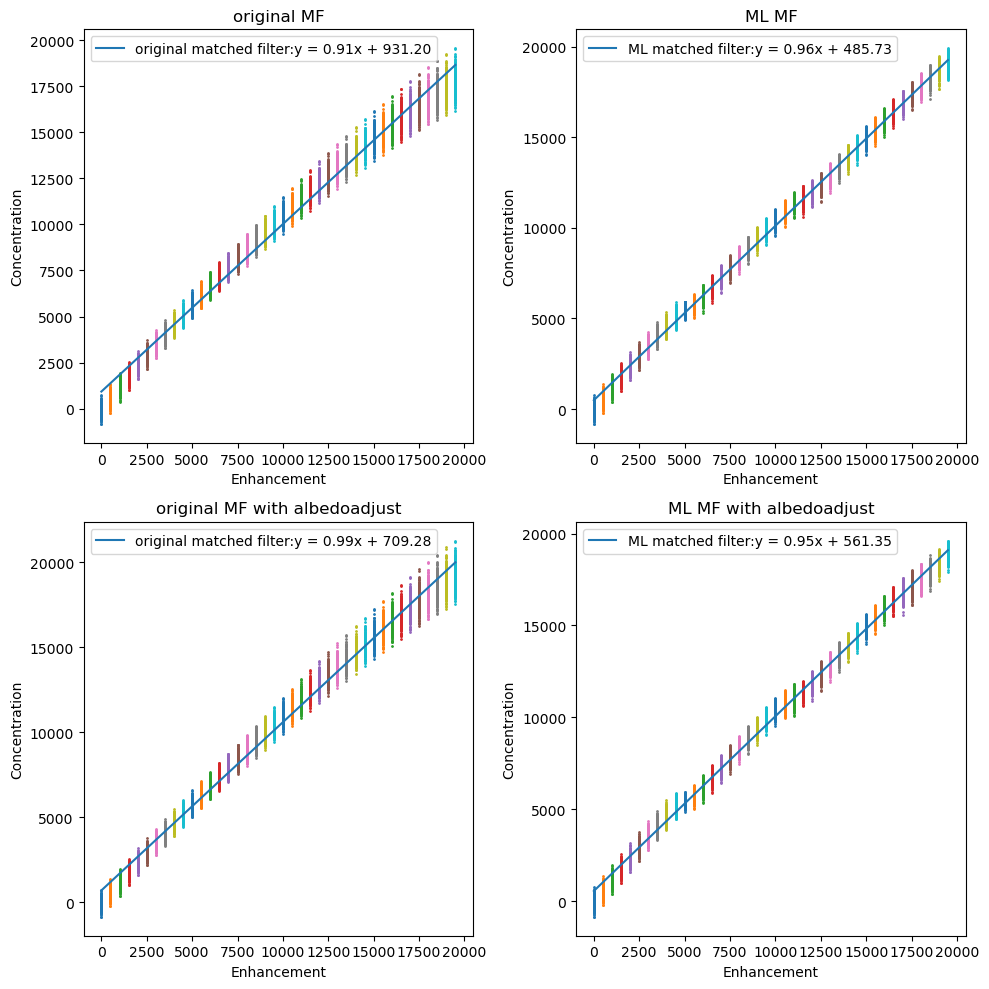

In [133]:

def ML_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array,albedoadjust) -> np.array:
    """
    Calculate the methane enhancement of the image data based on the modified matched filter
    and the unit absorption spectrum.

    :param data_cube: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param albedoadjust: bool, whether to adjust the albedo
    :param sparsity: bool, whether to use l1filter
    :return: numpy array of methane enhancement result
    """
    # 获取波段 行数 列数 初始化 concentration 数组，大小与卫星数据尺寸一直
    bands, rows, cols = data_cube.shape
    concentration = np.zeros((rows, cols))
    
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    background_spectrum = np.nanmean(data_cube, axis=(1,2))
    target_spectrum = background_spectrum*unit_absorption_spectrum[0]
    radiancediff_with_bg = data_cube - background_spectrum[:, None,None]
    
    # 计算协方差矩阵，并获得其逆矩阵
    d_covariance = radiancediff_with_bg
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.pinv(covariance)
    
    # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
    albedo = np.ones((rows, cols))
    if albedoadjust:
        for row in range(rows):
            for col in range(cols):
                albedo[row, col] = (
                        (data_cube[:,row,col].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                )
    
    # 基于最优化公式计算每个像素的甲烷浓度增强值
    for row in range(rows):
        for col in range(cols):
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum)
            denominator = albedo[row,col]*(target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[row,col] = numerator/denominator

    # 备份原始浓度值
    original_concentration = concentration.copy()
    
    # 多层单位吸收光谱计算
    levelon = True
    adaptive_threshold = 6000
    i = 1
    high_concentration_mask = original_concentration > adaptive_threshold*(0.99**i)
    low_concentration_mask = original_concentration <= adaptive_threshold*(0.99**i)

    while levelon:
        if np.sum(high_concentration_mask) > 0 and adaptive_threshold < 32000:
            background_spectrum = np.nanmean(data_cube - concentration * target_spectrum[:, None, None], axis=(1, 2))
            target_spectrum = background_spectrum * unit_absorption_spectrum[0]
            
            new_background_spectrum = background_spectrum
            for n in range(i):
                new_background_spectrum += 6000*new_background_spectrum*unit_absorption_spectrum[n]
            high_target_spectrum = new_background_spectrum * unit_absorption_spectrum[i]
            
            radiancediff_with_bg[:,high_concentration_mask] = (
                data_cube[:,high_concentration_mask] - new_background_spectrum[:,None]
            )
            radiancediff_with_bg[:,low_concentration_mask] = (
                data_cube[:,low_concentration_mask] - background_spectrum[:,None]
            )
            
            # d_covariance[:,high_concentration_mask] = data_cube[:,high_concentration_mask] - (
            #     (concentration[high_concentration_mask]-adaptive_threshold)*high_target_spectrum[:,None] + new_background_spectrum[:,None]
            # )
            # d_covariance[:,high_concentration_mask] = data_cube[:,high_concentration_mask] - (
            #     background_spectrum[:,None] + concentration[high_concentration_mask]*target_spectrum[:,None]
            # )
            
            # d_covariance[:,low_concentration_mask] = data_cube[:,low_concentration_mask] - (
            #     background_spectrum[:,None] + concentration[low_concentration_mask]*target_spectrum[:,None]
            # )
            # covariance = np.zeros((bands, bands))
            # for row in range(rows):
            #     for col in range(cols):
            #         covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
            # covariance /= rows*cols
            # covariance_inverse = np.linalg.inv(covariance) 
            
            # concentration[high_concentration_mask] = (
            #     (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @high_target_spectrum) / 
            #     (high_target_spectrum.T @ covariance_inverse @ high_target_spectrum)
            # ) + adaptive_threshold
            
            concentration[high_concentration_mask] = (
                (radiancediff_with_bg[:, high_concentration_mask].T @ high_target_spectrum) / 
                (high_target_spectrum.T @  high_target_spectrum)
            ) + adaptive_threshold
            
            
            high_concentration_mask = original_concentration > adaptive_threshold*0.99
            low_concentration_mask = original_concentration <= adaptive_threshold*0.99
        
            adaptive_threshold += 6000
            i += 1

        else:
            levelon = False

    return original_concentration,concentration


def MLmf_run_plot(ax1,ax2,*args):
    uaslist = []
    _,uas = gu.generate_range_uas_AHSI(0,36000,2150,2500)
    uaslist.append(uas)
    uasrange = np.arange(4000,46000,4000)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)
    
    resultlist = []
    resultlist2 = []
    enhancements = np.arange(0,20000,500)
    for enhancement in enhancements:
        # 生成2%像素浓度增强的模拟影像
        simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
        # 使用匹配滤波算法计算浓度增强
        originalresult,result = ML_matched_filter(simulated_image,uaslist,*args)
        # 计算增强和未增强像素的平均浓度
        
        enhanced = originalresult[enhanced_mask]
        unenhanced = originalresult[unenhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax1.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        enhanced2 = result[enhanced_mask]
        unenhanced2 = result[unenhanced_mask]
        resultlist2.append(np.mean(enhanced2))
        ax2.plot(enhancement*np.ones(len(enhanced2)), enhanced2, marker='o', markersize = 1, linestyle='None')
    polyfit_plot(enhancements,resultlist,ax1,"original matched filter")
    polyfit_plot(enhancements,resultlist2,ax2,"ML matched filter")
    

def ML_matched_filter_test():
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = axes.flatten()
    
    MLmf_run_plot(ax1,ax2,False)
    MLmf_run_plot(ax3,ax4,True)
    

    set_plot_details(ax1, "original MF", "Enhancement", "Concentration")
    set_plot_details(ax2, "ML MF", "Enhancement", "Concentration")
    set_plot_details(ax3, "original MF with albedoadjust", "Enhancement", "Concentration")
    set_plot_details(ax4, "ML MF with albedoadjust", "Enhancement", "Concentration")

    plt.tight_layout()
    plt.show()
    
    return None

ML_matched_filter_test()


### column-wise 进行计算

In [ ]:

# modified matched filter algorithm 逐列计算
def columnwise_ML_matched_filter(data_array: np.array, stacked_unit_absorption_spectrum: np.array, is_iterate=False,
                   is_albedo=False, is_filter=False, is_columnwise=False) -> np.array:
    """
    Calculate the methane enhancement of the image data based on the original matched filter
    and the unit absorption spectrum.

    :param data_array: numpy array of the image data
    :param unit_absorption_spectrum: list of the unit absorption spectrum
    :param is_iterate: flag to decide whether to iterate the matched filter
    :param is_albedo: flag to decide whether to do the albedo correction
    :param is_filter: flag to decide whether to add the l1-filter correction
    :return: numpy array of methane enhancement result
    """
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_array.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 遍历不同列数，目的是为了消除 不同传感器之间带来的误差
    if is_columnwise:
        for col_index in range(cols):
            # 获取当前列的数据
            current_column = data_array[:, :, col_index]
            # 获取当前列的非空行的 索引 以及 数目
            valid_rows = ~np.isnan(current_column[0, :])
            count_not_nan = np.count_nonzero(valid_rows)
            # 对于全为空的列，直接将浓度值设为 nan
            if count_not_nan == 0:
                concentration[:, col_index] = np.nan
                continue

            # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
            background_spectrum = np.nanmean(current_column, axis=1)
            target_spectrum = background_spectrum*stacked_unit_absorption_spectrum[0,:]

            # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
            radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None]
            covariance = np.zeros((bands, bands))
            for i in range(count_not_nan):
                covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
            covariance = covariance/count_not_nan
            covariance_inverse = np.linalg.inv(covariance)

            # 判断是否进行反照率校正，若是，则通过背景光谱和实际光谱计算反照率校正因子
            albedo = np.ones((rows, cols))
            if is_albedo:
                albedo[valid_rows, col_index] = (
                        (current_column[:, valid_rows].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                )

            # 基于最优化公式计算每个像素的甲烷浓度增强值
            up = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum)
            down = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[valid_rows, col_index] = up / down
            
            levelon = True
            # 计算浓度增强值的均值和标准差
            mean_concentration = np.nanmean(concentration[valid_rows, col_index])  # 忽略 NaN 值
            std_concentration = np.nanstd(concentration[valid_rows, col_index])    # 忽略 NaN 值
            # 使用均值加一个标准差作为自适应阈值
            adaptive_threshold = mean_concentration + std_concentration
            while levelon:
                high_concentration_mask = concentration[valid_rows, col_index] > adaptive_threshold
                # 获取这个阈值的单位吸收谱，可以通过插值查找表获得
                # 使用新的单位吸收谱重新计算目标光谱
                background_spectrum = np.nanmean(current_column[:,valid_rows] + albedo[valid_rows,col_index]*concentration[valid_rows,col_index]*target_spectrum[:, np.newaxis], axis=1)
                background_spectrum = background_spectrum + adaptive_threshold*stacked_unit_absorption_spectrum[1,:]
                target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[1,:])
                radiancediff_with_bg = current_column[:, valid_rows] - background_spectrum[:, None] - albedo[valid_rows,col_index]*(concentration[valid_rows,col_index]-adaptive_threshold)*target_spectrum[:, np.newaxis] 
                covariance = np.zeros((bands, bands))
                for i in range(valid_rows.shape[0]):
                    covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                covariance = covariance/count_not_nan
                covariance_inverse = np.linalg.inv(covariance)
                # 基于新的目标光谱重新计算高浓度像素的甲烷浓度增强值
                up = (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @ target_spectrum)
                down = albedo[valid_rows, col_index][high_concentration_mask] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                # 直接更新原数组
                valid_indices = np.where(valid_rows)[0]
                high_concentration_indices = valid_indices[high_concentration_mask]
                concentration[high_concentration_indices, col_index] = up / down + adaptive_threshold
                # 计算浓度增强值的均值和标准差
                mean_concentration = np.nanmean(concentration[valid_rows, col_index])  # 忽略 NaN 值
                std_concentration = np.nanstd(concentration[valid_rows, col_index])    # 忽略 NaN 值
                # 使用均值加一个标准差作为自适应阈值
                new_adaptive_threshold = mean_concentration + std_concentration
                if np.abs((new_adaptive_threshold-adaptive_threshold)/adaptive_threshold) < 0.1:
                    adaptive_threshold = new_adaptive_threshold
                else:
                    levelon = False

            # 判断是否进行迭代，若是，则进行如下迭代计算
            if is_iterate:
                l1filter = np.zeros((rows, cols))
                epsilon = np.finfo(np.float32).tiny
                for iter_num in range(5):
                    if is_filter:
                        l1filter[valid_rows, col_index] = 1 / (concentration[valid_rows, col_index] + epsilon)
                    else:
                        l1filter[valid_rows, col_index] = 0
                    
                    # 更新背景光谱和目标光谱
                    column_replacement = current_column[:, valid_rows] - (albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None]
                    # 计算更新后的 背景光谱 和 目标谱
                    background_spectrum = np.mean(column_replacement, axis=1)
                    target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])
                    # 基于新的目标谱 和 背景光谱 计算协方差矩阵
                    radiancediff_with_bg = current_column[:, valid_rows] -(albedo[valid_rows, col_index] *concentration[valid_rows, col_index])[None,:]*target_spectrum[:,None] - background_spectrum[:,None]
                    covariance = np.zeros((bands, bands))
                    for i in range(valid_rows.shape[0]):
                        covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                    covariance = covariance/count_not_nan
                    covariance_inverse = np.linalg.inv(covariance)

                    # 计算新的甲烷浓度增强值
                    up = (radiancediff_with_bg.T @ covariance_inverse @ target_spectrum) - l1filter[valid_rows, col_index]
                    down = albedo[valid_rows, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                    concentration[valid_rows, col_index] = np.maximum(up / down, 0.0)
                    high_concentration_mask = concentration[valid_rows, col_index] > 5000
                    
                    if np.any(high_concentration_mask):
                        # 使用新的单位吸收谱重新计算目标光谱
                        con = concentration[valid_rows, col_index].copy()
                        background_spectrum = np.nanmean(current_column[:,valid_rows] - albedo[valid_rows,col_index]*con*target_spectrum[:, np.newaxis], axis=1)
                        target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum)
                        radiancediff_with_bg = current_column[:, valid_rows] -albedo[valid_rows,col_index]*con*target_spectrum[:, np.newaxis] - background_spectrum[:, None]
                        covariance = np.zeros((bands, bands))
                        for i in range(valid_rows.shape[0]):
                            covariance += np.outer(radiancediff_with_bg[:, i], radiancediff_with_bg[:, i])
                        covariance = covariance/count_not_nan
                        covariance_inverse = np.linalg.inv(covariance)
                        # 基于新的目标光谱重新计算高浓度像素的甲烷浓度增强值
                        up = (radiancediff_with_bg[:, high_concentration_mask].T @ covariance_inverse @ target_spectrum)
                        down = albedo[valid_rows, col_index][high_concentration_mask] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                        # 直接更新原数组
                        valid_indices = np.where(valid_rows)[0]
                        high_concentration_indices = valid_indices[high_concentration_mask]
                        concentration[high_concentration_indices, col_index] = up / down + 2500

    if not is_columnwise:
        count_not_nan = np.count_nonzero(~np.isnan(data_array[0, :, :]))
        background_spectrum = np.nanmean(data_array, axis=(1,2))
        target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])   
        radiancediff_with_bg = data_array - background_spectrum[:, None, None]
        covariance = np.zeros((bands, bands))
        for i in range(rows):
            for j in range(cols):
                covariance = covariance + np.outer(radiancediff_with_bg[:, i, j], radiancediff_with_bg[:, i, j])
        covariance = covariance / count_not_nan
        covariance_inverse = np.linalg.inv(covariance)
        albedo = np.ones((rows, cols))
        for row_index in range(rows):
            for col_index in range(cols):
                if is_albedo:
                    albedo[row_index, col_index] = (
                        (data_array[:, row_index, col_index].T @ background_spectrum) /
                        (background_spectrum.T @ background_spectrum)
                    )
                up = (radiancediff_with_bg[:,row_index,col_index].T @ covariance_inverse @ target_spectrum)
                down = albedo[row_index, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                concentration[row_index, col_index] = up / down
        
        if is_iterate:
            l1filter = np.zeros((rows, cols))
            epsilon = np.finfo(np.float32).tiny
            iter_data = data_array.copy()
            
            for iter_num in range(5):
                if is_filter:
                    l1filter = 1 / (concentration + epsilon)
                iter_data = data_array - (
                    target_spectrum[:, None, None] * albedo[None, :, :] * concentration[None, :, :]
                )
                background_spectrum = np.nanmean(iter_data, axis=(1,2))
                target_spectrum = np.multiply(background_spectrum, stacked_unit_absorption_spectrum[0,:])
                radiancediff_with_bg = data_array - background_spectrum[:, None, None]
                covariance = np.zeros((bands, bands))
                for i in range(rows):
                    for j in range(cols):
                        covariance += np.outer(radiancediff_with_bg[:, i, j], radiancediff_with_bg[:, i, j])
                covariance = covariance / count_not_nan
                covariance_inverse = np.linalg.inv(covariance)
                
                for row_index in range(rows):
                    for col_index in range(cols):
                        up = (radiancediff_with_bg[:, row_index, col_index].T @ covariance_inverse @ target_spectrum)
                        down = albedo[row_index, col_index] * (target_spectrum.T @ covariance_inverse @ target_spectrum)
                        concentration[row_index, col_index] = np.maximum(up / down, 0)

    # 返回 甲烷浓度增强的结果
    return concentration



## lognornal 匹配滤波算法

### 整幅影像进行计算

In [ ]:
# convert the radiance into log space 整幅图像进行计算
def lognormal_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array):
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_cube.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    log_background_spectrum = np.nanmean(np.log(data_cube), axis=(1,2))
    background_spectrum = np.exp(log_background_spectrum)
    
    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    radiancediff_with_bg = np.log(data_cube) - log_background_spectrum[:, None,None]
    d_covariance = np.log(data_cube)-background_spectrum[:,None,None]
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(d_covariance[:, row, col], d_covariance[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.inv(covariance)

    for row in range(rows):
        for col in range(cols):
            # 基于最优化公式计算每个像素的甲烷浓度增强值
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ unit_absorption_spectrum)
            denominator = (unit_absorption_spectrum.T @ covariance_inverse @ unit_absorption_spectrum)
            concentration[row,col] = numerator/denominator
    return concentration


### column-wise 进行计算

In [ ]:

# convert the radiance into log space 逐列计算
def columnwise_lognormal_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array):
    # 获取 以 波段 行数 列数 为顺序的数据
    bands, rows, cols = data_cube.shape
    # 初始化 concentration 数组，大小与卫星数据尺寸一直
    concentration = np.zeros((rows, cols))
    # 对于非空列，取均值作为背景光谱，再乘以单位吸收光谱，得到目标光谱
    background_spectrum = np.nanmean(data_cube, axis=(1,2))
    target_spectrum = background_spectrum*unit_absorption_spectrum

    # 对当前目标光谱的每一行进行去均值操作，得到调整后的光谱，以此为基础计算协方差矩阵，并获得其逆矩阵
    radiancediff_with_bg = data_cube - background_spectrum[:, None,None]
    covariance = np.zeros((bands, bands))
    for row in range(rows): 
        for col in range(cols):
            covariance += np.outer(radiancediff_with_bg[:, row, col], radiancediff_with_bg[:, row, col])
    covariance = covariance/(rows*cols)
    covariance_inverse = np.linalg.inv(covariance)

    for row in range(rows):
        for col in range(cols):
            # 基于最优化公式计算每个像素的甲烷浓度增强值
            numerator = (radiancediff_with_bg[:,row,col].T @ covariance_inverse @ target_spectrum)
            denominator = (target_spectrum.T @ covariance_inverse @ target_spectrum)
            concentration[row,col] = numerator/denominator
    return concentration



##  Kalman filter 匹配滤波算法

### 整幅影像进行计算

In [ ]:
def Kalman_filterr_matched_filter(data_cube: np.array, unit_absorption_spectrum: np.array, albedoadjust, iterate, sparsity):
    
    return None

# 算法验证

## 光谱测试
模拟的具备甲烷浓度增强的卫星光谱的匹配滤波拟合浓度增强

### 单层单位吸收光谱拟合

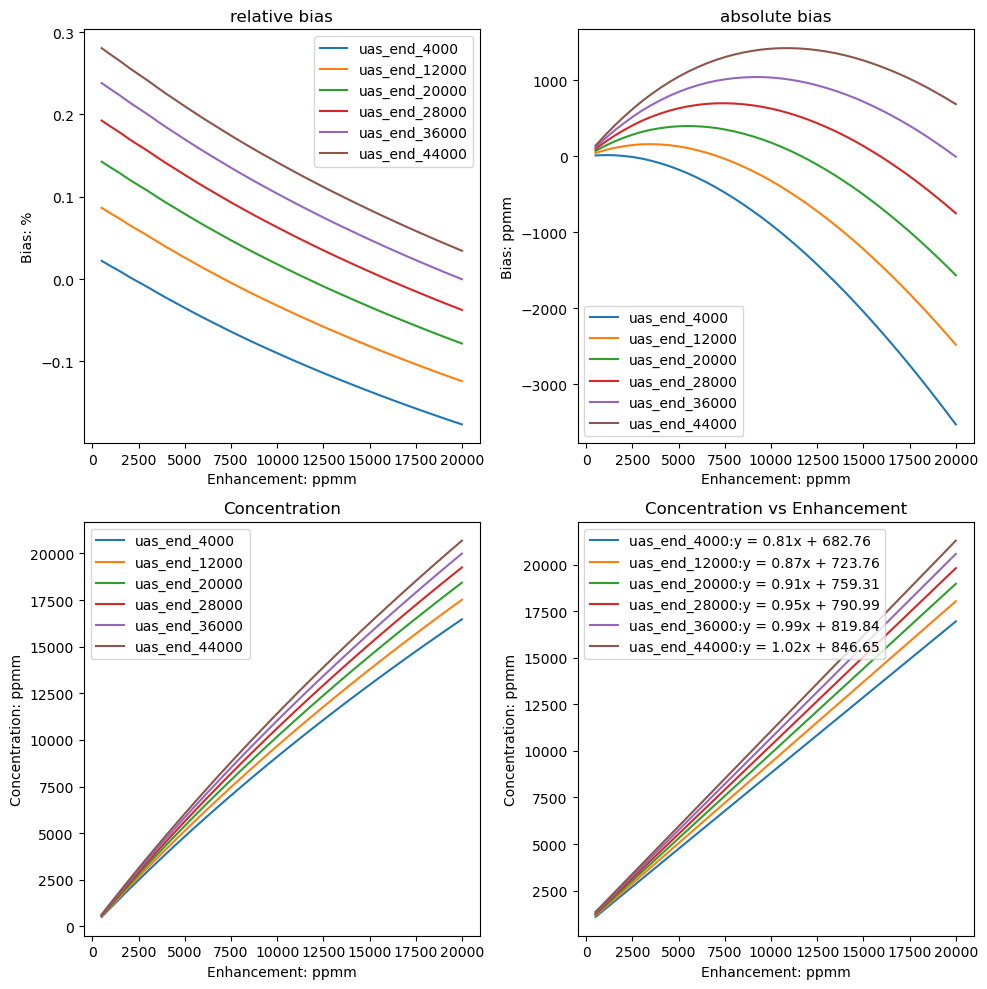

In [86]:
def spectrumlevel_test1():
    """
    测试不同浓度增强下的甲烷廓线直接拟合的浓度结果。 
    使用拟合区间不同的单位吸收光谱。
    """
   
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = ax.flatten()
    for end in range(4000,45000,8000):
        # 读取单位吸收光谱 UAS
        ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{end}.txt"
        _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        
        # 初始化变量
        base = None
        channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        _,base = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
        concentration = 0
        concentrationlist = []
        re_biaslists = []
        ab_biaslists = []
        # 拟合甲烷浓度增强
        enhancements = np.arange(500,20500,500)
        for enhancement in enhancements:
            # 读取模拟辐射数据
            filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{int(enhancement)}_ppmm_tape7.txt"
            _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
            # 通过直接拟合的方法计算甲烷浓度增强，并计算与实际值的偏差
            concentration = profile_matched_filter(base,radiance,uas)
            ab_biaslists.append(concentration-enhancement)
            re_biaslists.append(((concentration-enhancement)/enhancement))
            concentrationlist.append(concentration)

        ax1.plot(enhancements,re_biaslists,label=f"uas_end_{end}")
        ax2.plot(enhancements,ab_biaslists,label=f"uas_end_{end}")
        ax3.plot(enhancements,concentrationlist,label=f"uas_end_{end}")
        polyfit_plot(enhancements,concentrationlist,ax4,f"uas_end_{end}")
    
    set_plot_details(ax1,"relative bias","Enhancement: ppmm","Bias: %")
    set_plot_details(ax2,"absolute bias","Enhancement: ppmm","Bias: ppmm")
    set_plot_details(ax3,"Concentration","Enhancement: ppmm","Concentration: ppmm")
    set_plot_details(ax4,"Concentration vs Enhancement","Enhancement: ppmm","Concentration: ppmm")

    plt.tight_layout()
    plt.show()
    
    return re_biaslists,ab_biaslists

re_biaslists,ab_biaslists = spectrumlevel_test1()


### 多层单位吸收光谱拟合

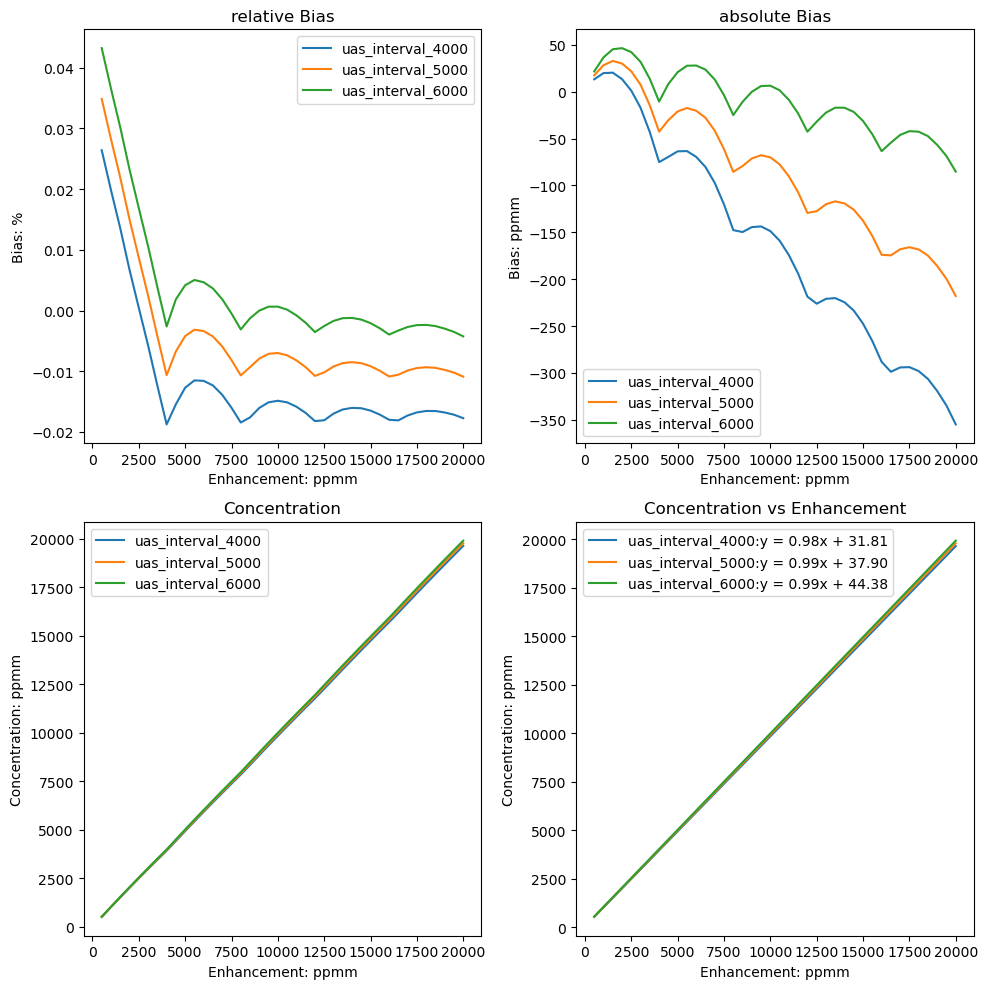

In [96]:
def spectrumlevel_test2():
    """
    测试不同浓度增强下的甲烷廓线拟合的浓度结果,使用多级单位吸收光谱。
    并与单级单位吸收光谱的结果进行对比。
    """ 
    # 可视化
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = ax[0,0],ax[0,1],ax[1,0],ax[1,1]
    for interval in range(4000,7000,1000):
        # 读取多级单位吸收光谱,并存储在列表中
        uaslist = []
        uasrange = np.arange(0,46000,4000)
        for i in uasrange:
            # ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{i}.txt"
            # _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
            _,uas = gu.generate_range_uas_AHSI(i,i+interval,2150,2500)
            uaslist.append(uas)
        
        # 读取背景光谱
        channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        _,base_radiance = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
        
        ml_concentrationlist = []
        ml_biaslists = []
        ml_difflists = []
        
        # 拟合甲烷浓度增强
        enhancements = np.arange(500,20500,500)
        for enhancement in enhancements:
            # 读取模拟辐射数据
            filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{enhancement}_ppmm_tape7.txt"
            _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
        
            concentration = profile_matched_filter_ML(base_radiance,radiance,uaslist)
            ml_biaslists.append(((concentration-enhancement)/enhancement))
            ml_difflists.append(concentration-enhancement)
            ml_concentrationlist.append(concentration)
        
        ax1.plot(enhancements,ml_biaslists,label=f"uas_interval_{interval}")
        ax2.plot(enhancements,ml_difflists,label=f"uas_interval_{interval}")
        ax3.plot(enhancements,ml_concentrationlist,label=f"uas_interval_{interval}")
        polyfit_plot(enhancements,ml_concentrationlist,ax4,f"uas_interval_{interval}")

    set_plot_details(ax1, "relative Bias", "Enhancement: ppmm", "Bias: %")
    set_plot_details(ax2, "absolute Bias", "Enhancement: ppmm", "Bias: ppmm")
    set_plot_details(ax3, "Concentration", "Enhancement: ppmm", "Concentration: ppmm")
    set_plot_details(ax4, "Concentration vs Enhancement", "Enhancement: ppmm", "Concentration: ppmm")
    
    plt.tight_layout()
    plt.show()
    
    return ml_biaslists,ml_difflists

ml_biaslists,ml_difflists = spectrumlevel_test2()


### 两种方式进行对比
选出最佳的参数对前两种方式中进行对比

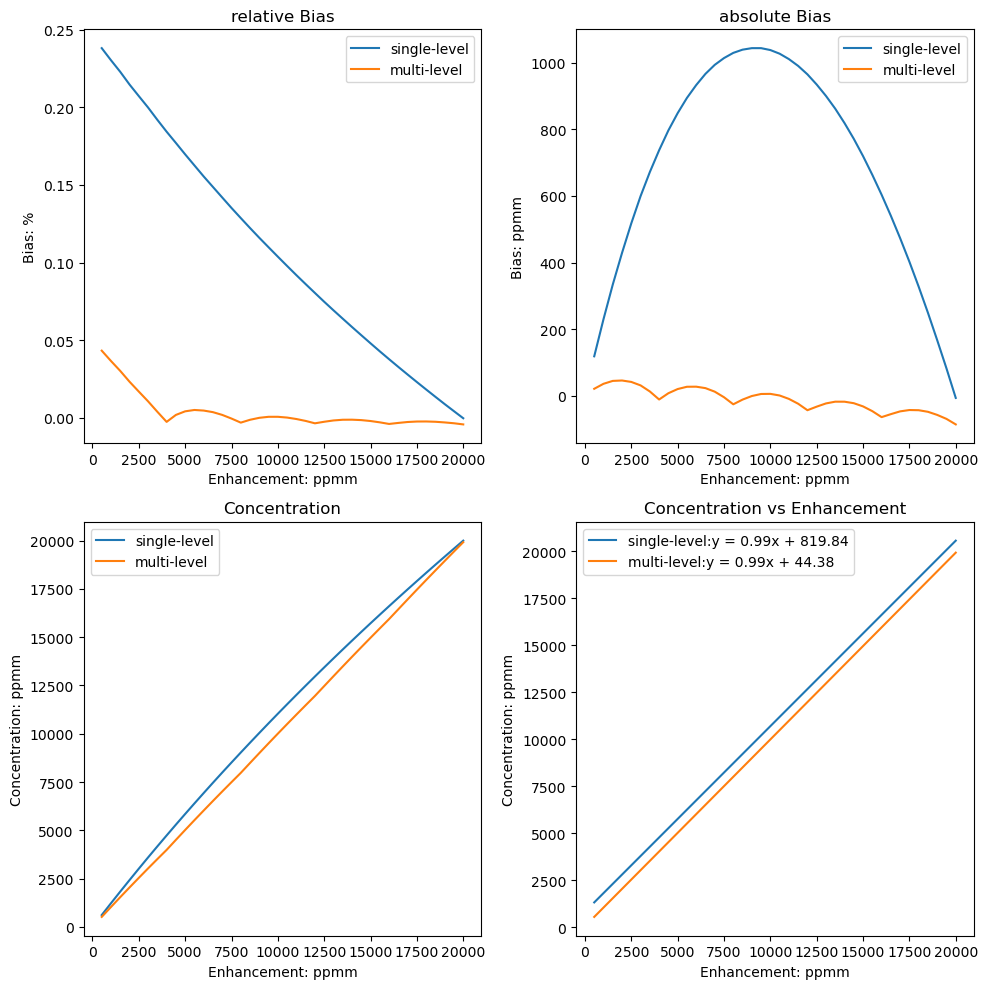

In [97]:

def spectrumlevel_test3():
    """
    测试不同浓度增强下的甲烷廓线拟合的浓度结果,使用多级单位吸收光谱。
    并与单级单位吸收光谱的结果进行对比。
    """
    # 读取单层单位吸收光谱    
    ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt"
    _,base_uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
    
    # 读取多级单位吸收光谱,并存储在列表中
    uaslist = []
    uasrange = np.arange(0,46000,4000)
    for i in uasrange:
        # ahsi_unit_absorption_spectrum_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_{i}.txt"
        # _,uas = nf.open_unit_absorption_spectrum(ahsi_unit_absorption_spectrum_path,2150,2500)
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)
    
    # 读取背景光谱
    channels_path=r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    base_filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    _,base_radiance = nf.get_simulated_satellite_radiance(base_filepath,channels_path,2150,2500)
    
    # initiatate variables
    sg_concentrationlist = []
    sg_biaslists = []
    sg_difflists = []
    
    ml_concentrationlist = []
    ml_biaslists = []
    ml_difflists = []
    
    # 拟合甲烷浓度增强
    enhancements = np.arange(500,20500,500)
    for enhancement in enhancements:
        # 读取模拟辐射数据
        filepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_{enhancement}_ppmm_tape7.txt"
        _,radiance = nf.get_simulated_satellite_radiance(filepath,channels_path,2150,2500)
    
        # 计算甲烷浓度增强，并计算与实际值的偏差
        concentration = profile_matched_filter(base_radiance,radiance,base_uas)
        sg_biaslists.append(((concentration-enhancement)/enhancement))
        sg_difflists.append(concentration-enhancement)
        sg_concentrationlist.append(concentration)
        
        concentration = profile_matched_filter_ML(base_radiance,radiance,uaslist)
        ml_biaslists.append(((concentration-enhancement)/enhancement))
        ml_difflists.append(concentration-enhancement)
        ml_concentrationlist.append(concentration)
        
    # 可视化
    fig, ax = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = ax[0,0],ax[0,1],ax[1,0],ax[1,1]
    
    ax1.plot(enhancements,sg_biaslists,label="single-level")
    ax1.plot(enhancements,ml_biaslists,label="multi-level")
    ax2.plot(enhancements,sg_difflists,label="single-level")
    ax2.plot(enhancements,ml_difflists,label="multi-level")
    ax3.plot(enhancements,sg_concentrationlist,label="single-level")
    ax3.plot(enhancements,ml_concentrationlist,label="multi-level")
    polyfit_plot(enhancements,sg_concentrationlist,ax4,"single-level")
    polyfit_plot(enhancements,ml_concentrationlist,ax4,"multi-level")
    
    set_plot_details(ax1, "relative Bias", "Enhancement: ppmm", "Bias: %")
    set_plot_details(ax2, "absolute Bias", "Enhancement: ppmm", "Bias: ppmm")
    set_plot_details(ax3, "Concentration", "Enhancement: ppmm", "Concentration: ppmm")
    set_plot_details(ax4, "Concentration vs Enhancement", "Enhancement: ppmm", "Concentration: ppmm")
    
    plt.tight_layout()
    plt.show()
    
    return sg_biaslists,ml_biaslists

ml_biaslists,sg_biaslists = spectrumlevel_test3()

## 模拟影像测试_1(背景光谱已知)
此测试针对 受到 统一浓度的随机 2% 像素的甲烷浓度增强的模拟影像，背景光谱已知，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

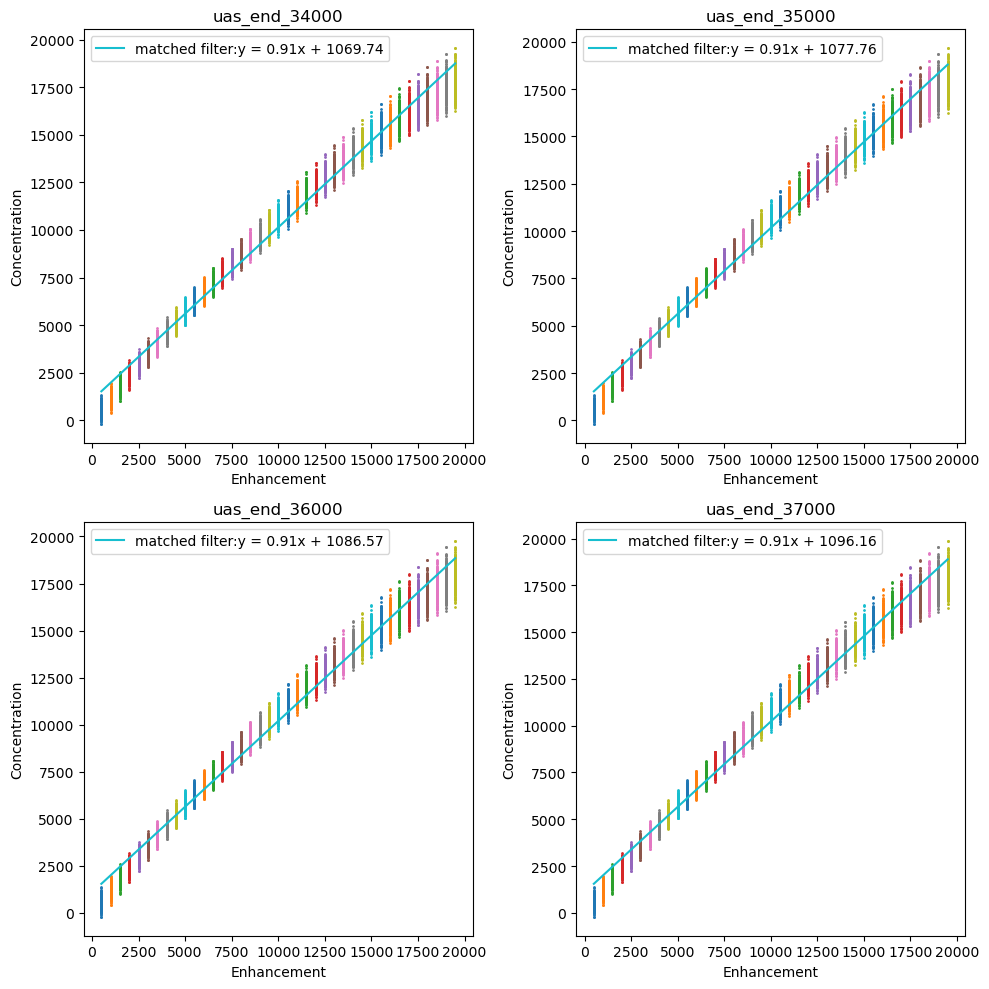

In [99]:
def imagelevel_test2_1():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    axf = ax.flatten()
    i = 0
    for end in range(34000,38000,1000):
        # 读取 AHSI 单位吸收谱
        ax1 = axf[i]
        _,uas = gu.generate_range_uas_AHSI(0,end,2150,2500)
        
        # 读取背景光谱
        basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
        channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
        _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
        
        resultlist = []
        
        enhancements = np.arange(500,20000,500)
        for enhancement in enhancements:
            # 生成2%像素浓度增强的模拟影像
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            
            # 使用匹配滤波算法计算浓度增强
            result = matched_filter_with_fixed_bg(base_radiance,simulated_image, uas)
            
            # 计算增强和未增强像素的平均浓度
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax1.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        polyfit_plot(enhancements,resultlist,ax1,"matched filter")
        set_plot_details(ax1, f"uas_end_{end}", "Enhancement", "Concentration")
        i += 1
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test2_1()

### 多层匹配滤波算法

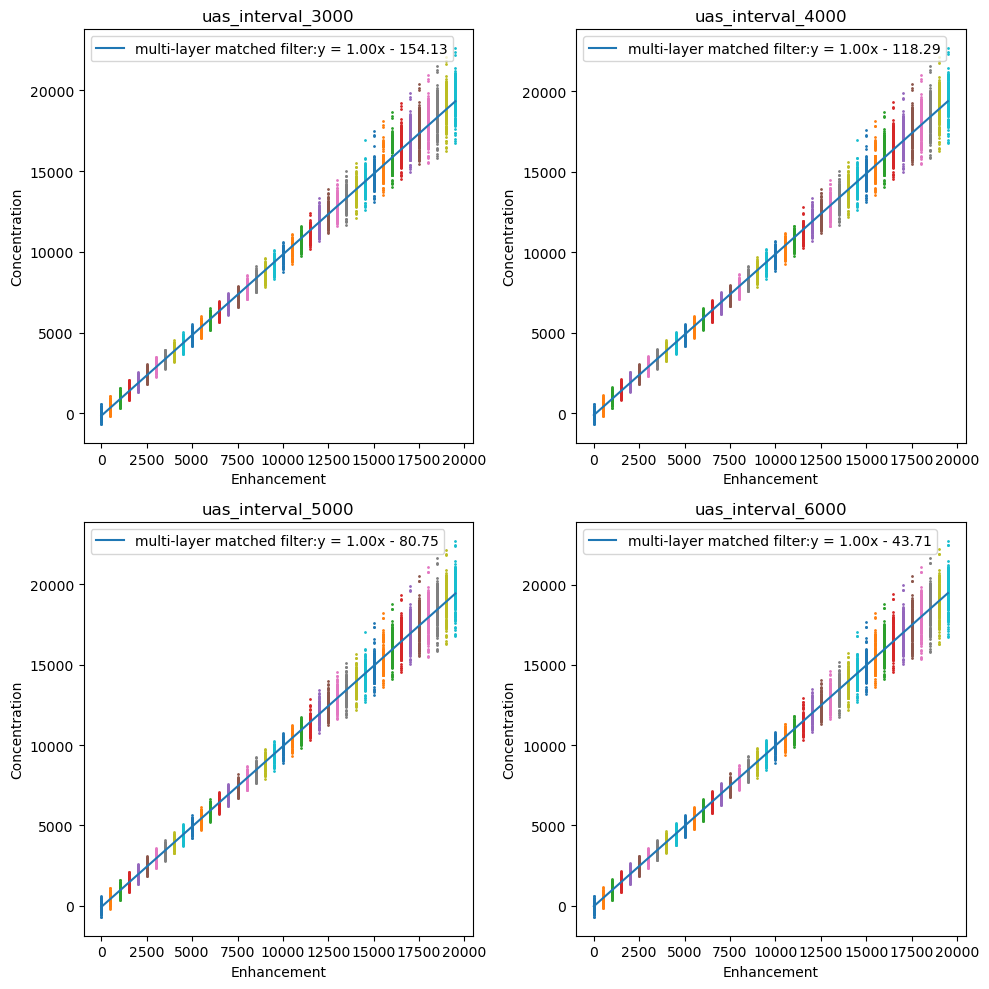

In [106]:
def imagelevel_test2_2():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用多层匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    # 读取背景光谱
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    fig,ax = plt.subplots(2,2,figsize=(10,10))
    axf = ax.flatten()
    axindex = 0
    for interval in range(3000,7000,1000):
        # 读取 AHSI 单位吸收谱
        uaslist = []
        uasrange = np.arange(0,46000,4000)
        for i in uasrange:
            _,uas = gu.generate_range_uas_AHSI(i,i+interval,2150,2500)
            uaslist.append(uas)
        
        enhancements = np.arange(0,20000,500)
        ax1 = axf[axindex]
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            # 使用匹配滤波算法计算浓度增强
            result = ML_matched_filter_with_fixed_bg(base_radiance,simulated_image, uaslist)
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax1.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        polyfit_plot(enhancements,resultlist,ax1,"multi-layer matched filter")
        set_plot_details(ax1, f"uas_interval_{interval}", "Enhancement", "Concentration")
        axindex += 1
    plt.tight_layout()
    plt.show()
    
    return resultlist

resultlist = imagelevel_test2_2()


### 两种算法进行对比

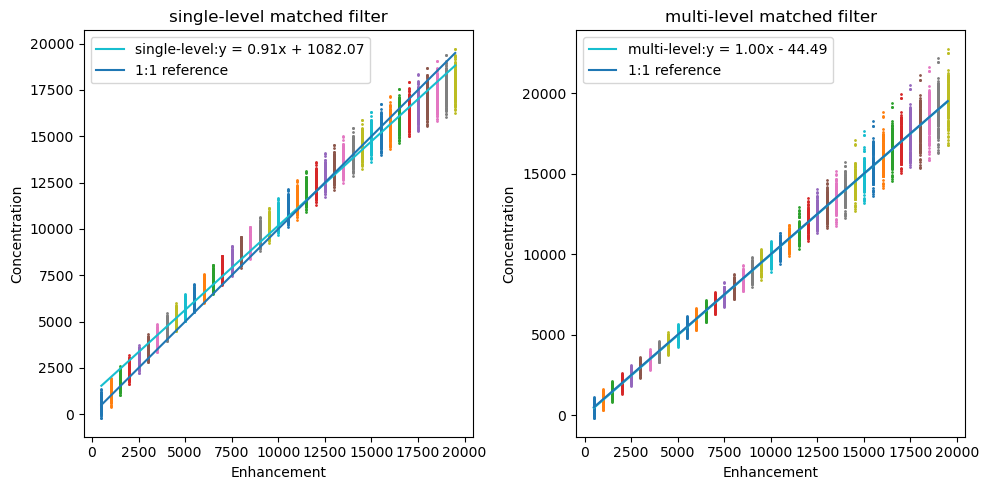

In [111]:
def imagelevel_test2_12():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱已知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    resultlist1 = []
    resultlist2 = []
    
    
    basefilepath = f"C:\\PcModWin5\\Bin\\batch\\AHSI_Methane_0_ppmm_tape7.txt"
    channels_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\AHSI_channels.npz"
    _,base_radiance = nf.get_simulated_satellite_radiance(basefilepath,channels_path,2150,2500)
    
    # 读取 AHSI 单位吸收谱
    uas_filepath = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt"
    _,base_uas = nf.open_unit_absorption_spectrum(uas_filepath,2150,2500)
    
    # 读取多层单位吸收光谱,并存储在列表中
    uaslist = []
    uasrange = np.arange(0,46000,4000)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)
    
    
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    enhancements = np.arange(500,20000,500)
    for enhancement in enhancements:
        simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
        
        # 使用匹配滤波算法计算浓度增强
        result = matched_filter_with_fixed_bg(base_radiance,simulated_image, base_uas)
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist1.append(np.mean(enhanced))
        ax[0].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        # 使用多层单位吸收光谱匹配滤波算法计算浓度增强
        result = ML_matched_filter_with_fixed_bg(base_radiance,simulated_image, uaslist)
        enhanced = result[enhanced_mask]
        unenhanced = result[unenhanced_mask]
        resultlist2.append(np.mean(enhanced))
        ax[1].plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
    polyfit_plot(enhancements,resultlist1,ax[0],"single-level")
    polyfit_plot(enhancements,resultlist2,ax[1],"multi-level")
    ax[0].plot(enhancements,enhancements,label="1:1 reference")
    ax[1].plot(enhancements,enhancements,label="1:1 reference")
    set_plot_details(ax[0], "single-level matched filter", "Enhancement", "Concentration")
    set_plot_details(ax[1], "multi-level matched filter", "Enhancement", "Concentration")
    plt.tight_layout()
    plt.show()
    return resultlist1,resultlist2

resultlist1,resultlist2 = imagelevel_test2_12()

## 模拟影像测试_2(背景光谱未知)
此测试针对 受到 统一浓度的随机 2% 像素的甲烷浓度增强的模拟影像，背景光谱未知，需要近似和不断修正，使用不同的匹配滤波算法
进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

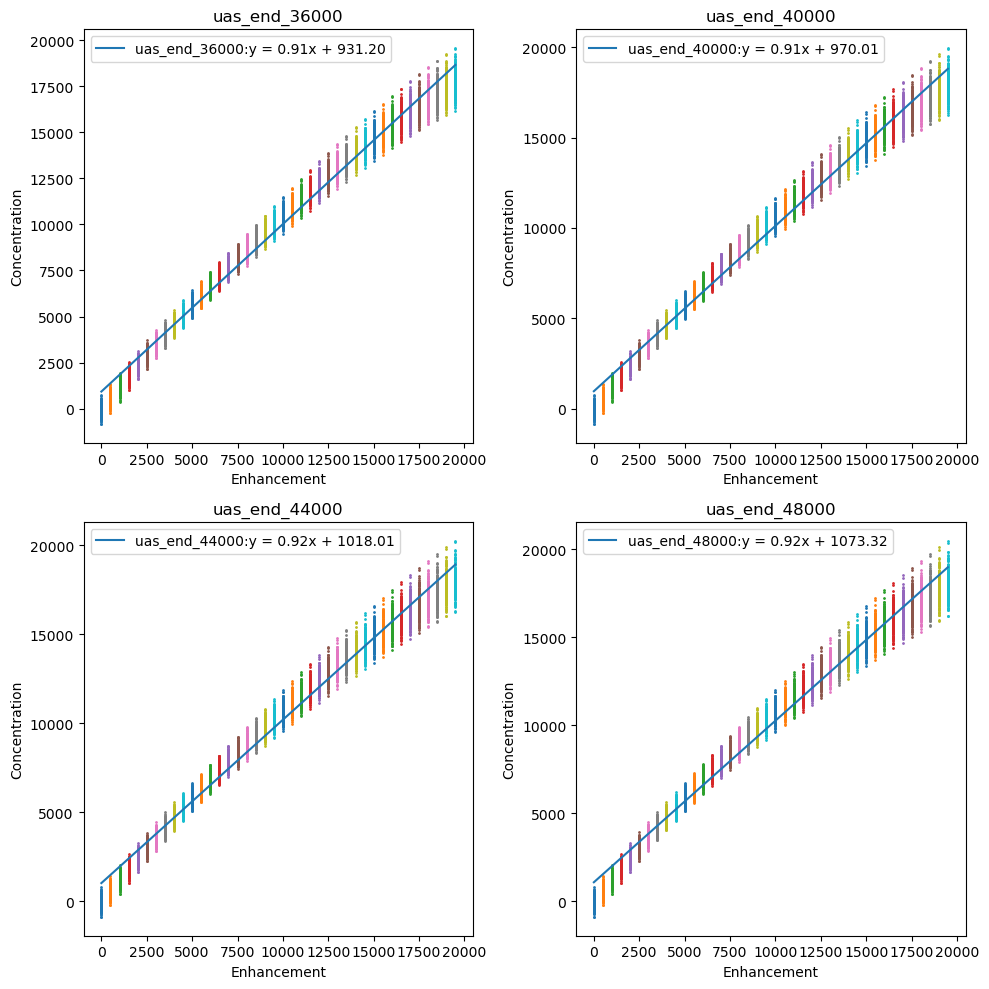

In [143]:
def imagelevel_test2_3():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    使用不同的单位吸收光谱
    """
    # 读取 AHSI 单位吸收谱
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    axf = axes.flatten()
    axindex = 0
    for end in range(36000,50000,4000):
        ax = axf[axindex]
        # 读取单位吸收光谱
        _,uas = gu.generate_range_uas_AHSI(0,end,2150,2500)
        enhancements = np.arange(0,20000,500)
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            result = mf.matched_filter(simulated_image, uas, iterate = False, albedoadjust=False, sparsity= False)
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        polyfit_plot(enhancements,resultlist,ax,f"uas_end_{end}")
    
        set_plot_details(ax, f"uas_end_{end}", "Enhancement", "Concentration")
        axindex += 1
    
    plt.tight_layout()
    plt.show()
    
    return resultlist
    
resultlist = imagelevel_test2_3()

### 多层匹配滤波算法

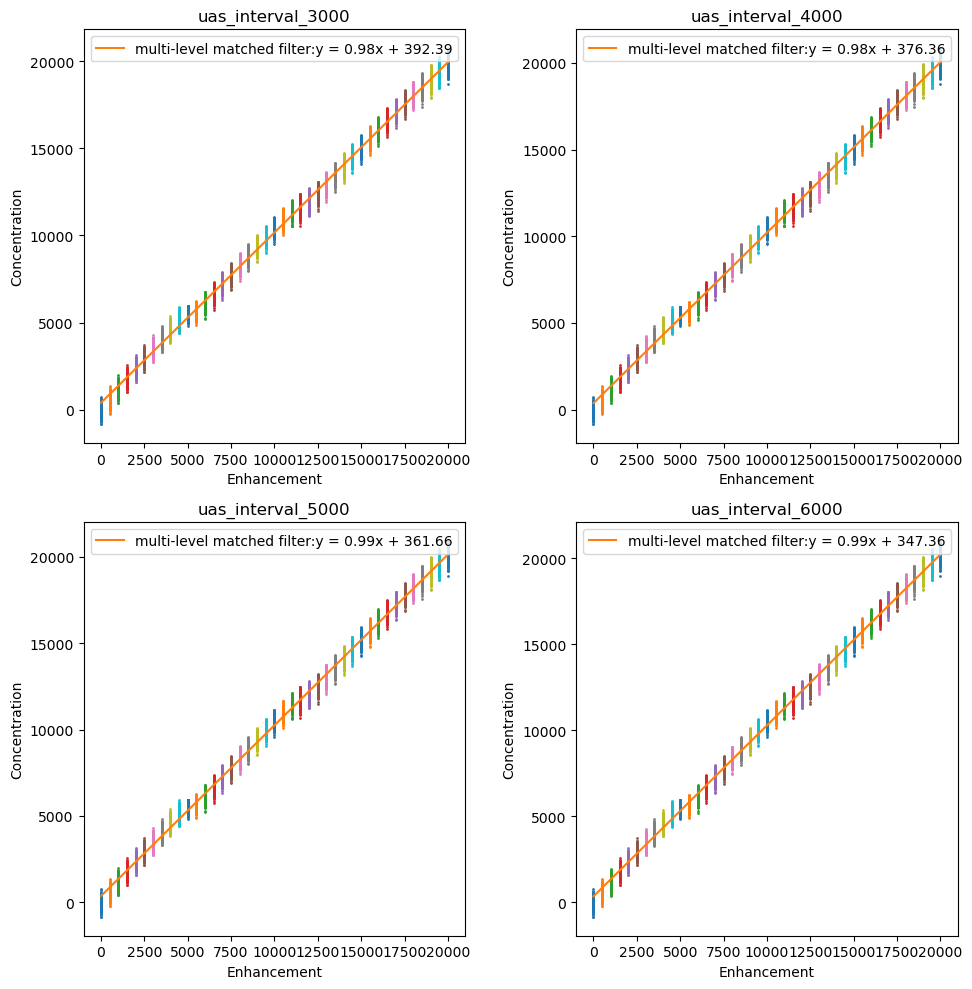

In [142]:
def imagelevel_test2_4():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强反演结果，
    背景光谱未知，使用不同的匹配滤波算法或者参数,并绘制浓度曲线图和bias曲线图
    """
    fig,axes = plt.subplots(2,2,figsize=(10,10))
    axf = axes.flatten()
    axindex = 0
    for interval in range(3000,7000,1000):
        ax = axf[axindex]
        # 读取单位吸收光谱列表
        uaslist = []
        _,uas = gu.generate_range_uas_AHSI(0,36000,2150,2500)
        uaslist.append(uas)
        uasrange = np.arange(6000,46000,6000)
        for i in uasrange:
            _,uas = gu.generate_range_uas_AHSI(i,i+interval,2150,2500)
            uaslist.append(uas)
        
        
        enhancements = np.arange(0,20500,500)
        resultlist = []
        for enhancement in enhancements:
            simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
            _,result = ML_matched_filter(simulated_image, uaslist,False)
            
            enhanced = result[enhanced_mask]
            unenhanced = result[unenhanced_mask]
            resultlist.append(np.mean(enhanced))
            ax.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        polyfit_plot(enhancements,resultlist,ax,"multi-level matched filter")
        set_plot_details(ax, f"uas_interval_{interval}", "Enhancement", "Concentration")
        axindex += 1
    
    plt.tight_layout()
    plt.show()
    return resultlist
    
resultlist = imagelevel_test2_4()

### 两种算法对比
基于前两个测试的最佳参数，对两者的反演结果进行对比。

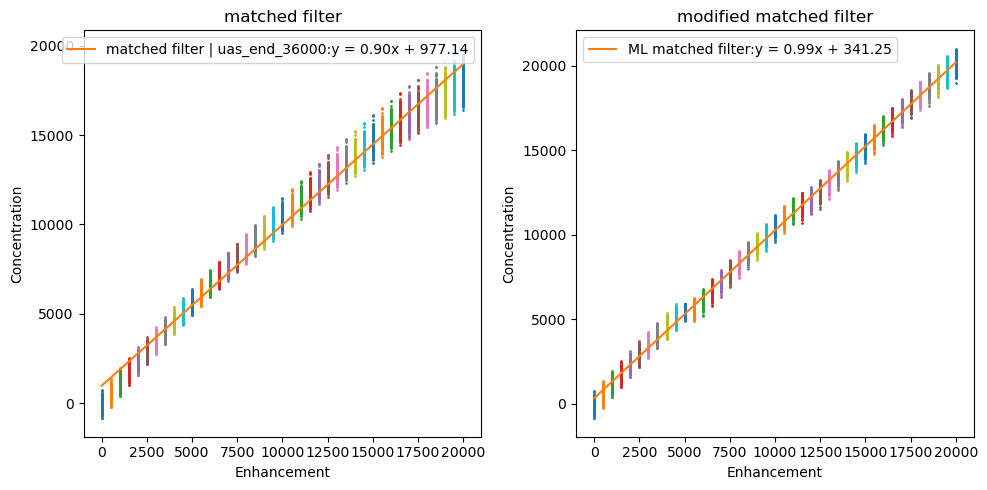

In [145]:
def imagelevel_test2_34():
    """ 
    测试随机 2% 像素的统一浓度的甲烷浓度增强的反演结果
    背景光谱未知，使用多层的单位吸收光谱
    并拟合出浓度增强与实际浓度增强的关系，
    """
    # 读取背景光谱
    uas_path = r"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\uas\\AHSI_UAS_end_36000.txt"
    _,general_uas = nf.open_unit_absorption_spectrum(uas_path,2150,2500)
    
    # 读取多层单位吸收光谱,并存储在列表中
    uaslist = []
    uaslist.append(general_uas)
    uasrange = np.arange(6000,46000,6000)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+6000,2150,2500)
        uaslist.append(uas)
    
    # 可视化
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ax1,ax2 = ax[0],ax[1]
    
    # 生成不同浓度增强的模拟影像，并计算浓度增强
    enhancements = np.arange(0,20500,500)
    resultlist = []
    resultlist2 = []
    for enhancement in enhancements:
        simulated_image,enhanced_mask,unenhanced_mask = enhancement_2perc(enhancement)
        
        # 使用匹配滤波算法计算浓度增强
        result = matched_filter(simulated_image, general_uas,False,False,False)
        enhanced = result[enhanced_mask]
        resultlist.append(np.mean(enhanced))
        ax1.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
        _,result = ML_matched_filter(simulated_image, uaslist,False)
        enhanced = result[enhanced_mask]
        resultlist2.append(np.mean(enhanced))
        ax2.plot(enhancement*np.ones(len(enhanced)), enhanced, marker='o', markersize = 1, linestyle='None')
        
    # 创建一个新的 x 值数组用于绘制拟合直线
    polyfit_plot(enhancements,resultlist,ax1,"matched filter | uas_end_36000")
    polyfit_plot(enhancements,resultlist2,ax2,"ML matched filter")
    
    set_plot_details(ax1, "matched filter", "Enhancement", "Concentration")
    set_plot_details(ax2, "modified matched filter", "Enhancement", "Concentration")
    
    plt.tight_layout()
    plt.show()
    return resultlist,resultlist2

resultlist1,resultlist2 = imagelevel_test2_34()

## 模拟影像测试_3(高斯烟羽)
此测试针对 叠加了高斯烟羽甲烷浓度增强分布的模拟影像，背景光谱未知，需要通过近似和修正来贴近真实背景光谱
使用不同的匹配滤波算法进行浓度的反演，并对结果进行一定的统计。

### 常规匹配滤波算法

C:\Users\RS\AppData\Local\Temp\ipykernel_36536\3663452450.py:81: RuntimeWarning: overflow encountered in scalar divide
  concentration[row,col] = np.maximum(numerator / denominator, 0.0)


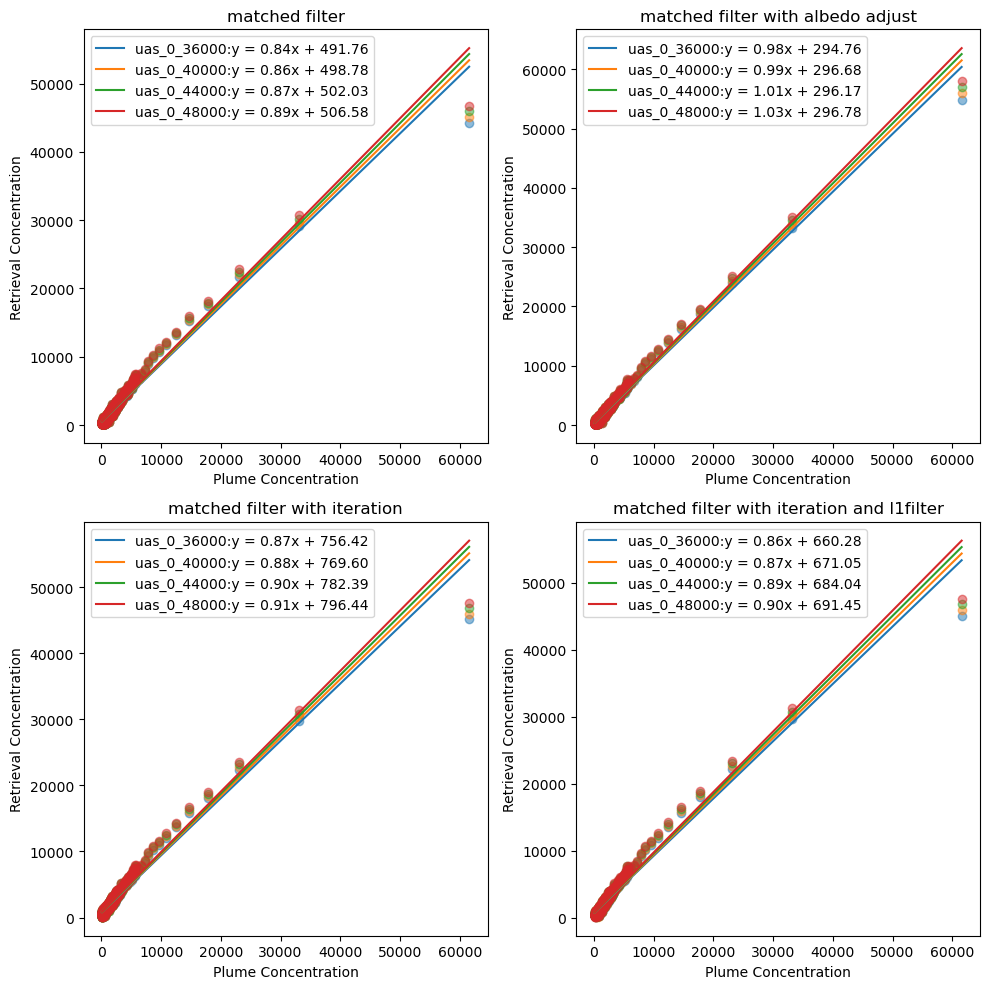

In [149]:
def imagelevel_test3_1():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 加载烟羽和叠加烟羽的模拟影像
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    fig, axes = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2,ax3,ax4 = axes.flatten()
    
    sub_function(plume,simulated_image,ax1,False,False,False)
    sub_function(plume,simulated_image,ax2,True,False,False)
    sub_function(plume,simulated_image,ax3,False,True,False)
    sub_function(plume,simulated_image,ax4,False,True,True)       
    set_plot_details(ax1, "matched filter", "Plume pixel Concentration", "Retrieval Concentration")
    set_plot_details(ax2, "matched filter with albedo adjust", "Plume pixel Concentration", "Retrieval Concentration")
    set_plot_details(ax3, "matched filter with iteration", "Plume pixel Concentration", "Retrieval Concentration")
    set_plot_details(ax4, "matched filter with iteration and l1filter", "Plume pixel Concentration", "Retrieval Concentration")
    
    plt.tight_layout()
    plt.show()
    
    return None

def sub_function(plume,simulated_image,ax,*args):
    for end in range(36000,50000,4000):
            # 加载单位吸收谱并生成匹配滤波算法的结果
            _,uas = gu.generate_range_uas_AHSI(0,end,2150,2500)
            enhancement = matched_filter(simulated_image, uas,*args)
            
            plume_mask = plume > 100
            result_mask = enhancement > 100
            total_mask = plume_mask*result_mask
            
            # 可视化
            ax.scatter(plume[total_mask],enhancement[total_mask], alpha=0.5)
            polyfit_plot(plume[total_mask].flatten(),enhancement[total_mask].flatten(), ax, f"uas_0_{end}")
        
            # # 对烟羽反演结果进行量化
            # molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
            # molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
            # emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
            # retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6

imagelevel_test3_1()

### 多层匹配滤波算法

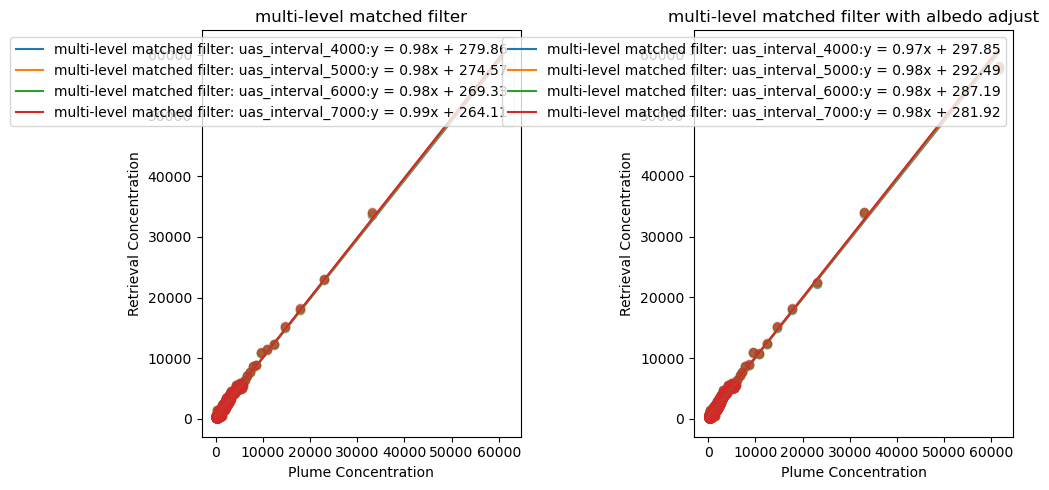

In [157]:
def imagelevel_test3_2():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽模型
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       

    # 读取单位吸收光谱列表
    fig, ax = plt.subplots(1,2,figsize=(10, 5))
    ax1,ax2 = ax.flatten()
    for interval in range(4000,8000,1000):
        uaslist = []
        _,uas = gu.generate_range_uas_AHSI(0,36000,2150,2500)
        uaslist.append(uas)
        uasrange = np.arange(6000,46000,6000)
        for i in uasrange:
            _,uas = gu.generate_range_uas_AHSI(i,i+interval,2150,2500)
            uaslist.append(uas)

        sub_function_2(plume,simulated_image,uaslist,ax1,interval,False)
        sub_function_2(plume,simulated_image,uaslist,ax2,interval,True)
        set_plot_details(ax1, "multi-level matched filter", "Plume Concentration", "Retrieval Concentration")
        set_plot_details(ax2, "multi-level matched filter with albedo adjust", "Plume Concentration", "Retrieval Concentration")
    plt.tight_layout()
    plt.show()
    
    return None


def sub_function_2(plume,simulated_image,uaslist,ax,interval,*args):
    # 加载单位吸收谱并生成匹配滤波算法的结果
    _,enhancement = ML_matched_filter(simulated_image, uaslist,*args)
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask*result_mask
    
    # 可视化
    ax.scatter(plume[total_mask],enhancement[total_mask], alpha=0.5)
    polyfit_plot(plume[total_mask].flatten(),enhancement[total_mask].flatten(), ax, f"multi-level matched filter: uas_interval_{interval}")

    # 对烟羽反演结果进行量化
    molar_mass_CH4 = 16.04  # 甲烷的摩尔质量，g/mol
    molar_volume_STP = 0.0224  # 摩尔体积，m^3/mol at STP
    emission = np.sum(plume[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6
    retrieval_emission = np.sum(enhancement[total_mask])*900*(molar_mass_CH4/molar_volume_STP) * 1e-6


imagelevel_test3_2()

### 两种算法对比

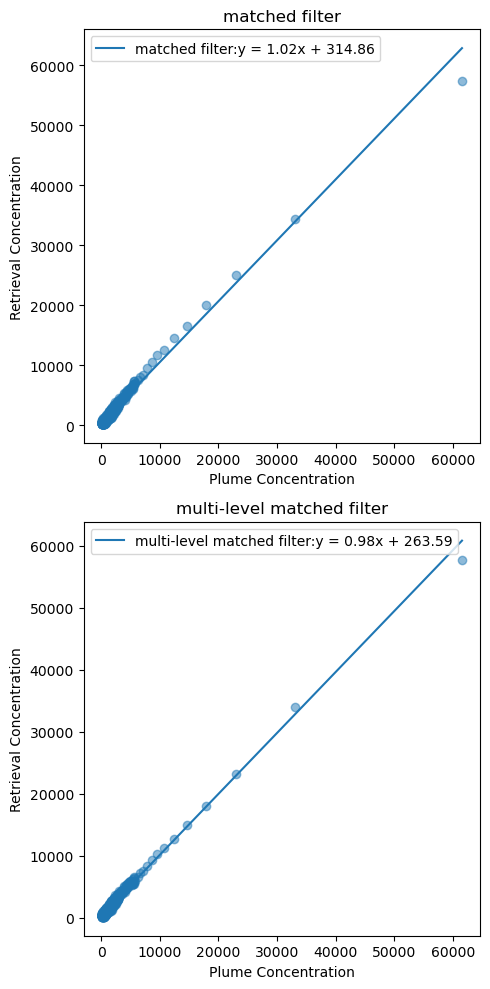

In [162]:
def imagelevel_test3_3():
    """ 
    对叠加了高斯扩散模型的甲烷烟羽模拟影像进行浓度反演
    """
    # 读取烟羽 以及 叠加了烟羽的模拟影像
    plume_path = f"C:\\Users\\RS\\VSCode\\matchedfiltermethod\\MyData\\plumes\\gaussianplume_1000_2_stability_D.npy"
    plume = np.load(plume_path)
    simulated_image = image_simulation(plume, 2150, 2500, 100, 100, 0.01)       
    _,general_uas = gu.generate_range_uas_AHSI(0,44000,2150,2500)
    
    # 读取单位吸收光谱列表
    uaslist = []
    _,uas = gu.generate_range_uas_AHSI(0,36000,2150,2500)
    uaslist.append(uas)
    uasrange = np.arange(6000,46000,6000)
    for i in uasrange:
        _,uas = gu.generate_range_uas_AHSI(i,i+7000,2150,2500)
        uaslist.append(uas)

    fig, axes = plt.subplots(2,2,figsize=(10,10))
    ax1,ax2 = axes.flatten()
    
    enhancement= matched_filter(simulated_image, general_uas,True,False,False)
    plume_mask = plume > 100
    result_mask = enhancement > 100
    total_mask = plume_mask*result_mask
    
    ax1.scatter(plume[total_mask],enhancement[total_mask], alpha=0.5)
    polyfit_plot(plume[total_mask].flatten(),enhancement[total_mask].flatten(), ax1, f"matched filter")

    _,enhancement2= ML_matched_filter(simulated_image, uaslist,False)
    plume_mask = plume > 100
    result_mask = enhancement2 > 100
    total_mask = plume_mask*result_mask
    
    ax2.scatter(plume[total_mask],enhancement2[total_mask], alpha=0.5)
    ax2.plot(plume[total_mask],plume[total_mask],label="1:1 reference")
    polyfit_plot(plume[total_mask].flatten(),enhancement2[total_mask].flatten(), ax2, f"multi-level matched filter")

    set_plot_details(ax1, "matched filter", "Plume Concentration", "Retrieval Concentration")
    set_plot_details(ax2, "multi-level matched filter", "Plume Concentration", "Retrieval Concentration")
    
    plt.tight_layout()
    plt.show()
    
    return None

imagelevel_test3_3()